In [63]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_predict
rcParams['figure.figsize'] = 10, 6

## Read Data <a name="read-data"></a>

Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: airplane passengers. To make plotting graphs easier, we set the index of pandas dataframe to the Month. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis


In [10]:
paris_df = pd.read_csv('./data/metropoles_consumption/eco2mix-Paris.csv', sep=';')
paris_df.head()

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
0,200054781,Métropole du Grand Paris,Données temps réel,2023-09-05,21:15,2023-09-05T21:15:00+02:00,3618.0,ND,3598
1,200054781,Métropole du Grand Paris,Données temps réel,2023-09-05,23:30,2023-09-05T23:30:00+02:00,3278.0,ND,3262
2,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:00,2023-09-06T00:00:00+02:00,3034.0,ND,3018
3,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:15,2023-09-06T00:15:00+02:00,2941.0,ND,2921
4,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:30,2023-09-06T00:30:00+02:00,2877.0,ND,2857


In [11]:
# see the number of rows where consumption = 0
print('Number of rows with consumption data = 0: ', len(paris_df[paris_df['Consommation (MW)'] == 0]))

# replace rows where consumption = 0 with the mean of the 3 previous and 3 next values

# get the indices of the rows where consumption = 0
zero_consumption_indices = paris_df[paris_df['Consommation (MW)'] == 0].index

# loop over the indices
for index in zero_consumption_indices:

  # get the mean of the 3 previous and 3 next values
  mean_consumption = paris_df.loc[index-3:index+3, 'Consommation (MW)'].mean()

  # replace the value with the mean
  paris_df.loc[index, 'Consommation (MW)'] = mean_consumption
print('Number of rows with consumption data = 0: ', len(paris_df[paris_df['Consommation (MW)'] == 0]))

Number of rows with consumption data = 0:  120
Number of rows with consumption data = 0:  0


In [12]:
# display nan values
paris_df.isna().sum()



Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)       3003
Production            179707
Echanges physiques    179707
dtype: int64

In [13]:
# replace rows where consumption = na with the mean of the 3 previous and 3 next values

# get the indices of the rows where consumption is na
na_consumption_indices = paris_df[paris_df['Consommation (MW)'].isna()].index

# loop over the indices
for index in na_consumption_indices:

  # get the mean of the 5 previous and 5 next values
  mean_consumption = paris_df.loc[index-2:index+2, 'Consommation (MW)'].mean()

  # replace the value with the mean
  paris_df.loc[index, 'Consommation (MW)'] = mean_consumption

# drop the rows where 'consumption' is still na
paris_df = paris_df.dropna(subset=['Consommation (MW)'])
# display nan values
paris_df.isna().sum()

Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)          0
Production            179707
Echanges physiques    179707
dtype: int64

In [14]:
# get time series of consumption
paris_consumption = paris_df['Consommation (MW)']

# get accompanying timesteps (date+hour converted to datetime)
paris_time = pd.to_datetime(paris_df['Date'] + ' ' + paris_df['Heures'], format='%Y-%m-%d %H:%M')


In [15]:
indexedDataset = paris_consumption

In [22]:
indexedDataset.head(5)

0    3618.0
1    3278.0
2    3034.0
3    2941.0
4    2877.0
Name: Consommation (MW), dtype: float64

From the plot below, we can see that there is a Trend compoenent in th series. Hence, we now check for stationarity of the data


In [16]:

# # Convert lists to numpy arrays
# time = np.array(paris_time)
# series = np.array(paris_consumption)

# # Preview the data
# plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

From the plot below, we can see that there is a Trend compoenent in th series. Hence, we now check for stationarity of the data


In [17]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
             ...     
238358    3396.083333
238359    3405.916667
238360    3417.333333
238361    3395.916667
238362    3417.500000
Name: Consommation (MW), Length: 238363, dtype: float64 0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
238358    534.230365
238359    525.545510
238360    512.901432
238361    548.904936
238362    523.200379
Name: Consommation (MW), Length: 238363, dtype: float64


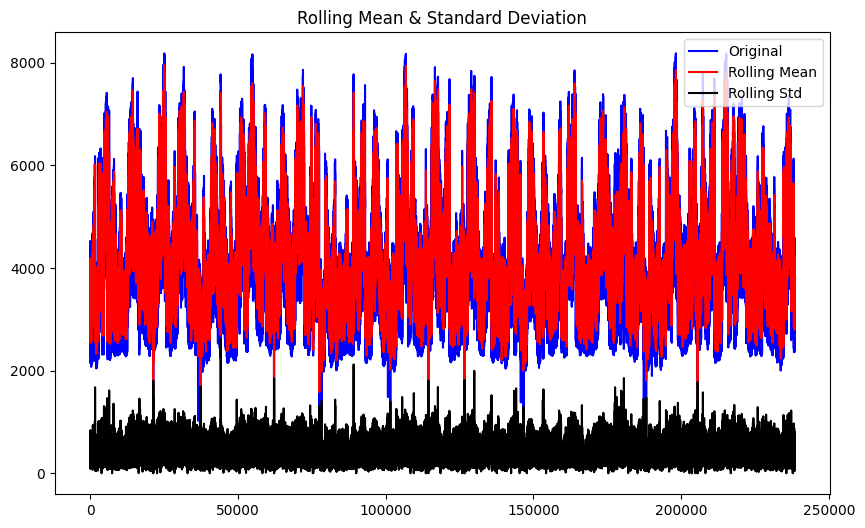

In [18]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.


In [23]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -1.629559e+01
p-value                        3.305097e-29
#Lags Used                     8.400000e+01
Number of Observations Used    2.382780e+05
Critical Value (1%)           -3.430377e+00
Critical Value (5%)           -2.861552e+00
Critical Value (10%)          -2.566776e+00
dtype: float64


For a Time series to be stationary, its ADCF test should have:

1. p-value to be low (according to the null hypothesis)
2. The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that **our Time Series at the moment is not stationary**


## Data Transformation to achieve Stationarity <a name="data-transform"></a>

There are a couple of ways to achieve stationarity through data transformation like taking $log_{10}$,$log_{e}$, square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.


### Log Scale Transformation <a name="log"></a>


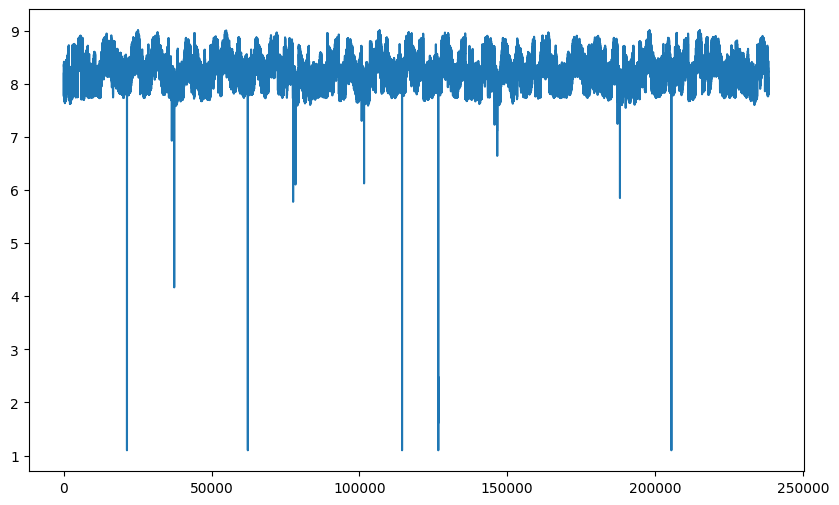

In [24]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

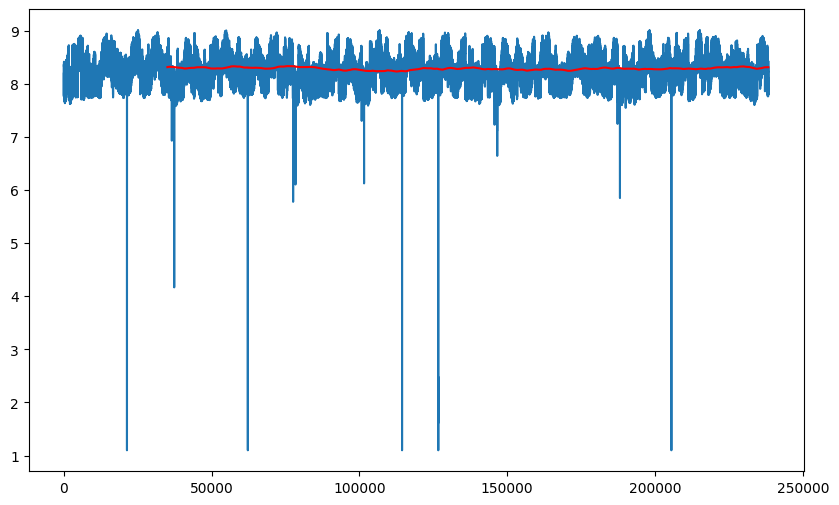

In [73]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=35040).mean()
movingSTD = indexedDataset_logScale.rolling(window=35040).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

$log scale L = stationary part(L1) + trend(LT)$  
$moving avg of log scale A = stationary part(A1) + trend(AT)$  
$result series R = L - A = (L1+LT) - (A1+AT) = (L1-A1) + (LT-AT)$

Since, L & A are series & it moving avg, their trend will be more or less same, Hence  
LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have,

$R = L1 - A1$, our final non-trend curve


In [26]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

11   -0.017583
12    0.115993
13    0.214610
14    0.277900
15    0.335198
16    0.319785
17    0.335983
18    0.300230
19    0.270044
20    0.221263
Name: Consommation (MW), dtype: float64

In [31]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

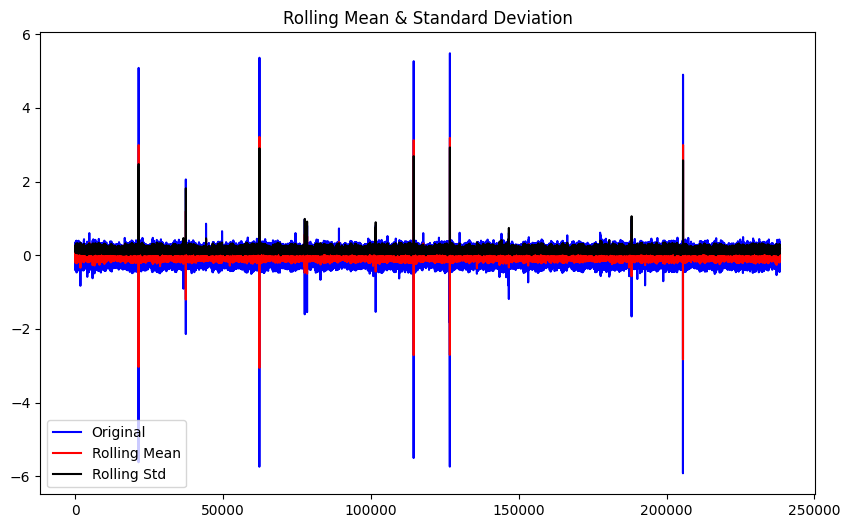

Results of Dickey Fuller Test:
Test Statistic                    -77.191300
p-value                             0.000000
#Lags Used                         84.000000
Number of Observations Used    238267.000000
Critical Value (1%)                -3.430377
Critical Value (5%)                -2.861552
Critical Value (10%)               -2.566776
dtype: float64


In [32]:
test_stationarity(datasetLogScaleMinusMovingAverage)

From above graph, we observe that our intuition that _"subtracting two related series having similar trend components will make the result stationary"_ is true. We find that:

1. p-value has reduced from 0.99 to 0.022.
2. The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic.
   Thus, from above 2 points, we can say that our given series is stationary.

But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.  
For further info, refer to my answer 12 at the top of the notebook on it.


### Exponential Decay Transformation <a name="exp"></a>


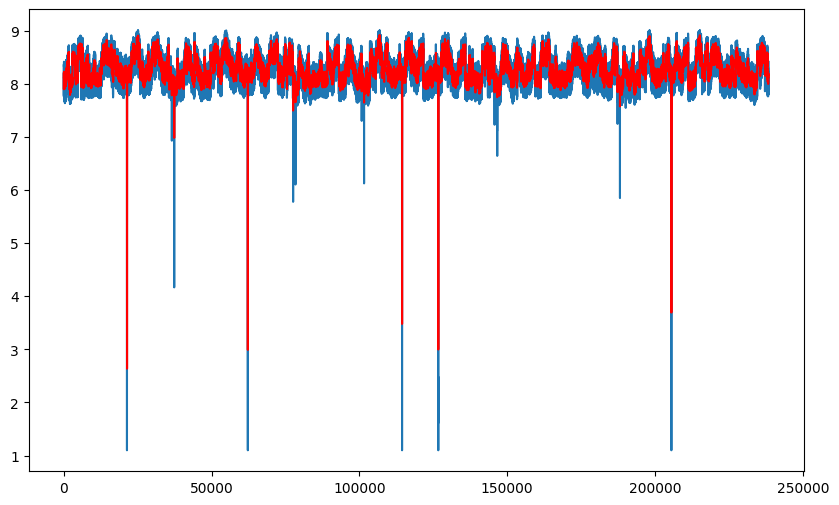

In [33]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. Hence, we perform the ADCF test again on the decay series below.


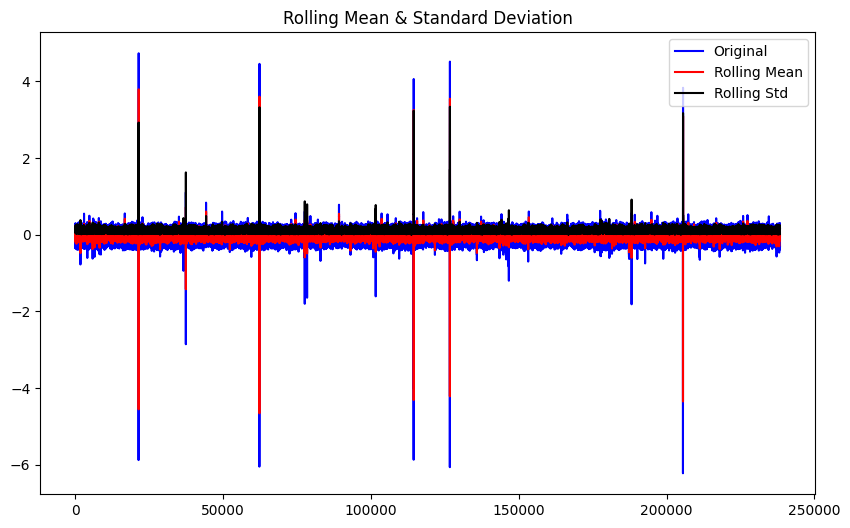

Results of Dickey Fuller Test:
Test Statistic                    -70.812262
p-value                             0.000000
#Lags Used                         84.000000
Number of Observations Used    238278.000000
Critical Value (1%)                -3.430377
Critical Value (5%)                -2.861552
Critical Value (10%)               -2.566776
dtype: float64


In [34]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.  
Also,

1. p-value has decreased from 0.022 to 0.005.
2. Test Statistic value is very much closer to the Critical values.  
   Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.

But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:

Given a set of observation on the time series:  
$ x0, x1, x2, x3, .... xn $

The shifted values will be:  
$ null, x0, x1, x2,.... xn $ <---- basically all xi's shifted by 1 pos to right

Thus, the time series with time shifted values are:  
$ null, (x1-x0), (x2-x1), (x3-x2), (x4-x3),.... (xn-x\_{n-1}) $


### Time Shift Transformation <a name="shift"></a>


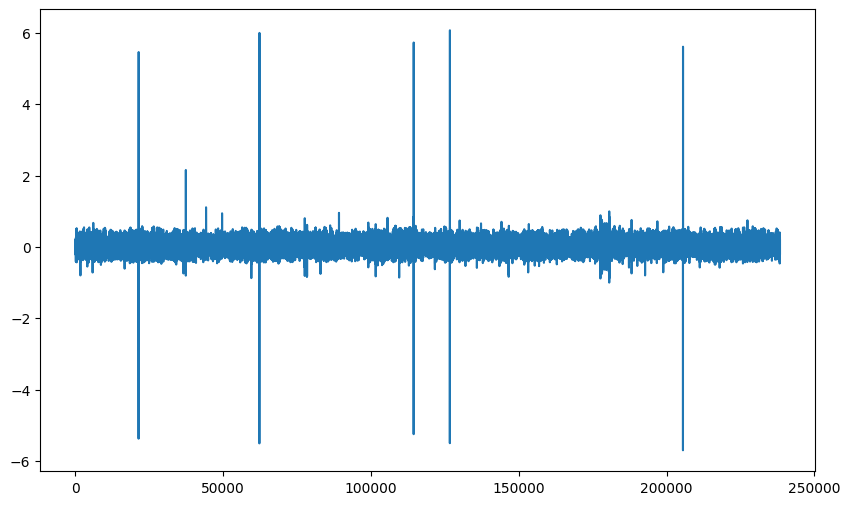

In [35]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

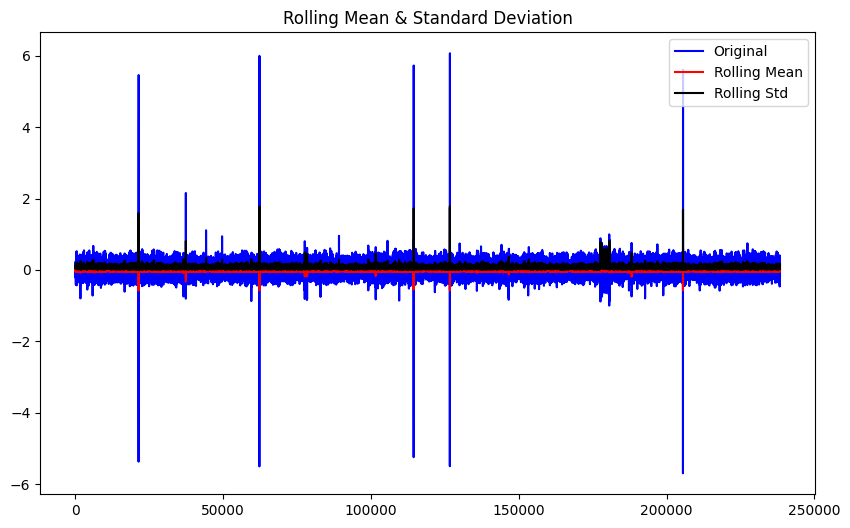

Results of Dickey Fuller Test:
Test Statistic                    -80.082826
p-value                             0.000000
#Lags Used                         84.000000
Number of Observations Used    238277.000000
Critical Value (1%)                -3.430377
Critical Value (5%)                -2.861552
Critical Value (10%)               -2.566776
dtype: float64


In [36]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

1. p-value of 0.07 is not as good as 0.005 of exponential decay.
2. Test Statistic value not as close to the critical values as that for exponential decay.

We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.


In [40]:
# type of indexedDataset_logScale (series?)
type(indexedDataset_logScale)

pandas.core.series.Series

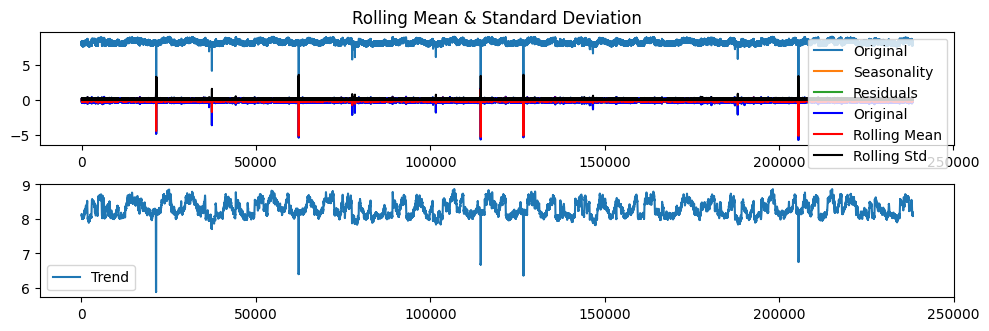

Results of Dickey Fuller Test:
Test Statistic                    -85.897747
p-value                             0.000000
#Lags Used                         84.000000
Number of Observations Used    238182.000000
Critical Value (1%)                -3.430377
Critical Value (5%)                -2.861552
Critical Value (10%)               -2.566776
dtype: float64


In [43]:
decomposition = seasonal_decompose(indexedDataset_logScale, period=4*24) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

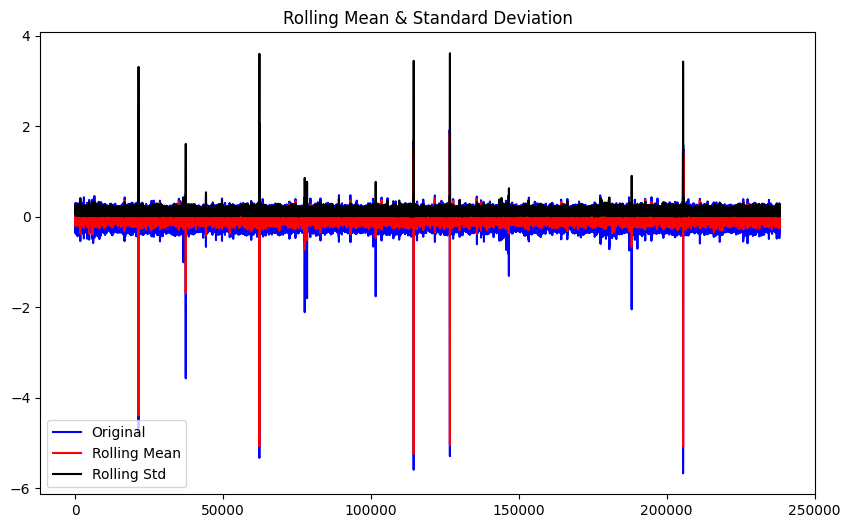

Results of Dickey Fuller Test:
Test Statistic                    -85.897747
p-value                             0.000000
#Lags Used                         84.000000
Number of Observations Used    238182.000000
Critical Value (1%)                -3.430377
Critical Value (5%)                -2.861552
Critical Value (10%)               -2.566776
dtype: float64


In [44]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

## Plotting ACF & PACF <a name="acf-pacf"></a>


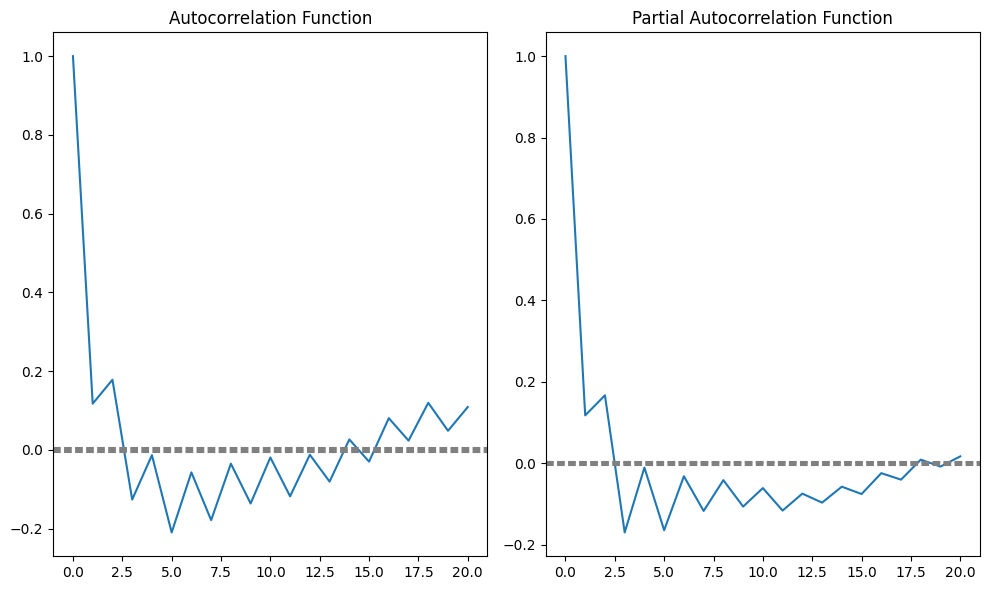

In [45]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2
From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.


## Building Models <a name="model"></a>


Plotting AR model


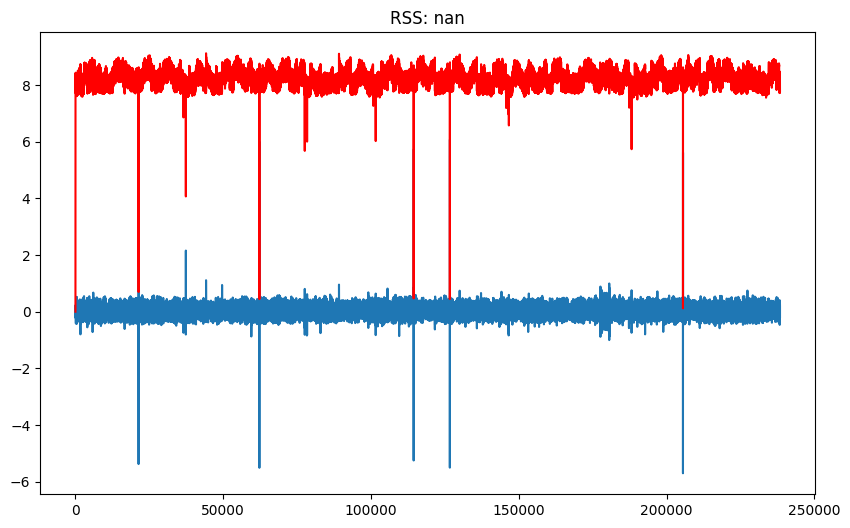

In [49]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting)**2))
print('Plotting AR model')

Plotting MA model


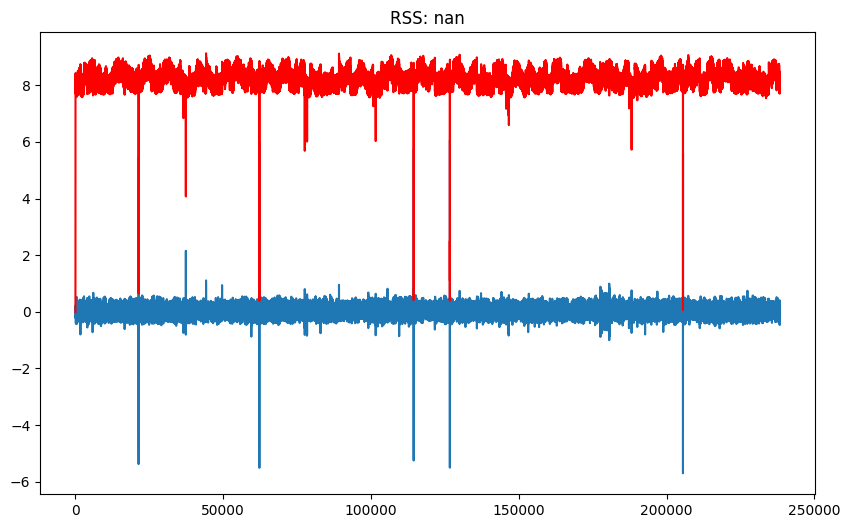

In [52]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting)**2))
print('Plotting MA model')

Plotting ARIMA model


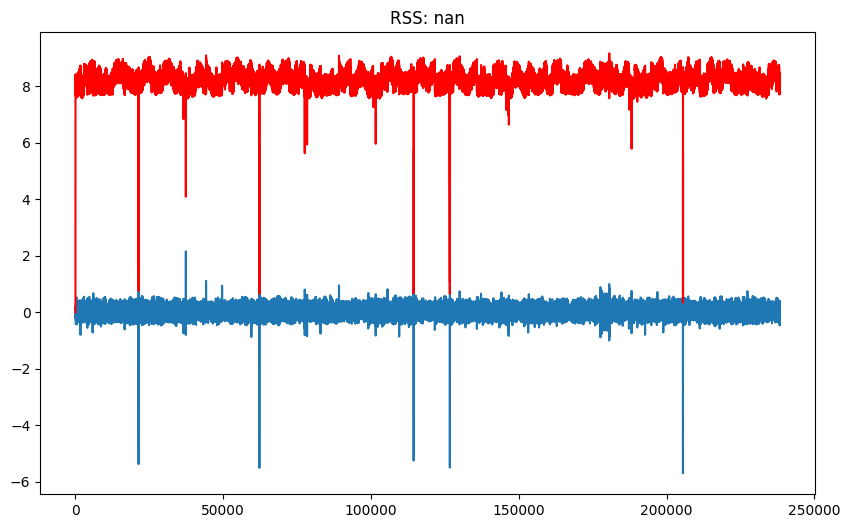

In [54]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting)**2))
print('Plotting ARIMA model')

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 1.0292, indicating ARIMA to be better than its individual component models.

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.


## Prediction & Reverse transformations <a name="prediction"></a>


In [55]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

0    0.000000
1    8.193677
2    8.083368
3    7.994087
4    7.980951
dtype: float64


In [56]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

0         0.000000e+00
1         8.193677e+00
2         1.627704e+01
3         2.427113e+01
4         3.225208e+01
              ...     
238358    1.975605e+06
238359    1.975613e+06
238360    1.975621e+06
238361    1.975629e+06
238362    1.975637e+06
Length: 238363, dtype: float64


In [59]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale.iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

0     8.193677
1    16.387353
2    24.470722
3    32.464808
4    40.445759
dtype: float64

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


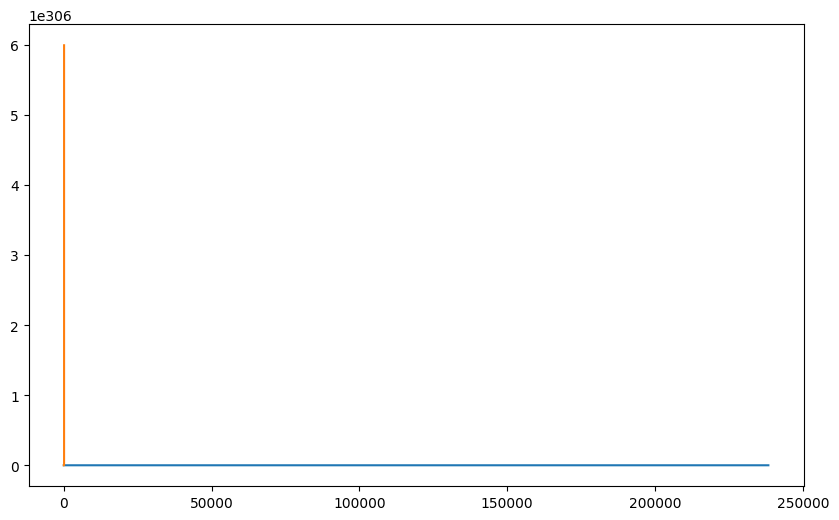

In [60]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.


In [61]:
indexedDataset_logScale

0         8.193677
1         8.094989
2         8.017637
3         7.986505
4         7.964503
            ...   
238358    8.232972
238359    8.016648
238360    7.990577
238361    7.807917
238362    7.989899
Name: Consommation (MW), Length: 238363, dtype: float64

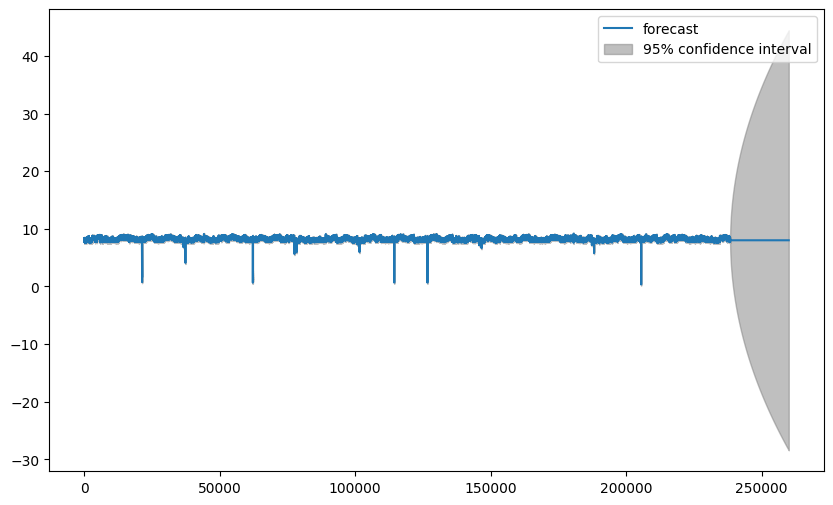

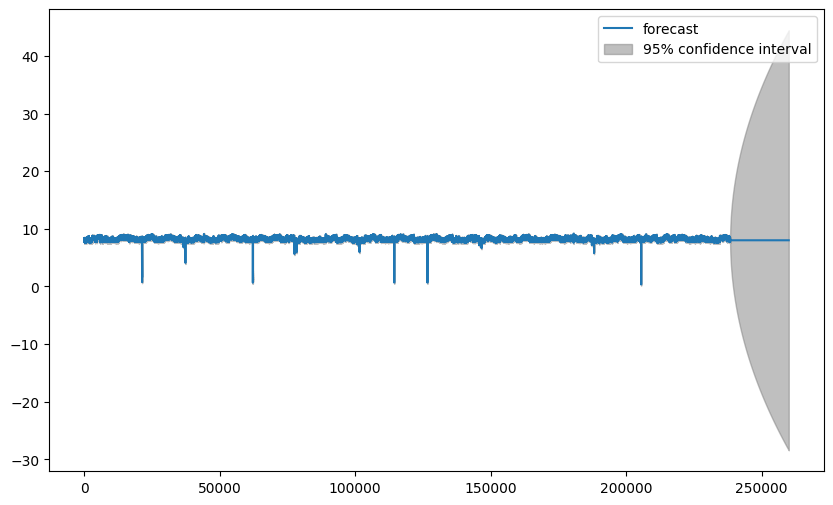

In [67]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
plot_predict(results_ARIMA, start=1, end=260000)
#x=results_ARIMA.forecast(steps=120)

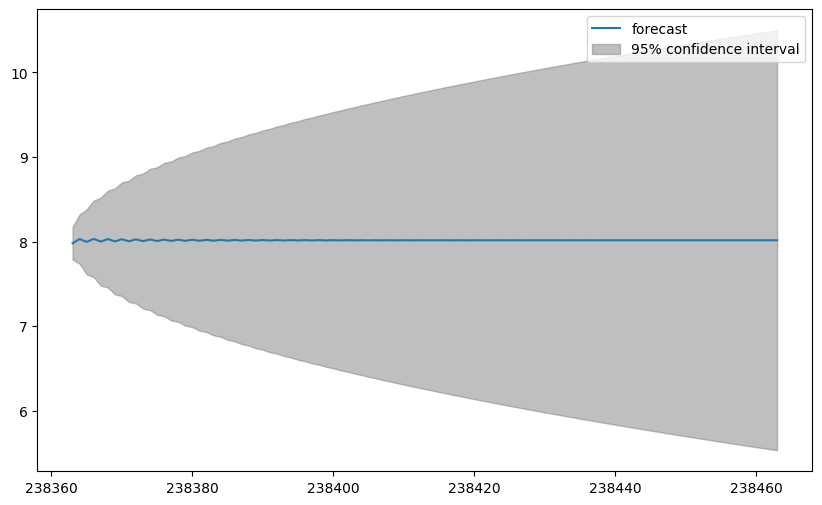

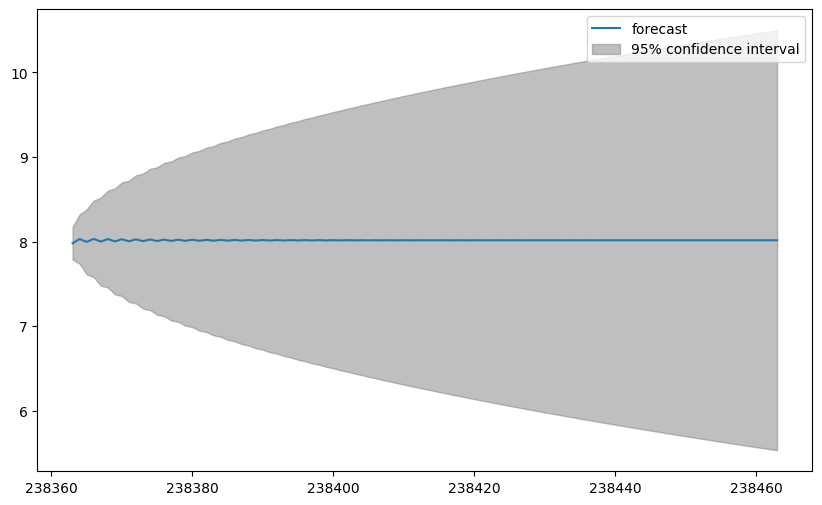

In [71]:
# zoom in on the first 100 predictions
plot_predict(results_ARIMA, start=len(indexedDataset_logScale), end=len(indexedDataset_logScale)+100)

In [ ]:
#print(x[1])
#print(len(x[1]))
#print(np.exp(x[1]))